In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import skorch
import numpy as np

from torch.autograd import Variable

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from sine_data import train_dataset, valid_dataset

The Gaussian clocking method is formally described as
$$
clk_{n} \sim \mathcal{N}(0, 1) \\
g_{n,t} = clk_{n} \cdot \sigma_{n} + \mu_{n} \\
\hat{y}_{n,t} = f(w_{n} x_{t} + u_{n} y_{n, t-1} + b_{n}) \\
y_{n,t} = g_{n,t} \hat{y}_{n,t} + (1 - g_{n,t}) y_{n,t}
$$

where $\mu_{n}$, $\sigma_{n}$, $w$, $u$ and $b$ are learnable parameters.

In [4]:
class GaussClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh'):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.m = nn.Parameter(torch.ones(hidden_dim) - 0.5)
        self.s = nn.Parameter(torch.ones(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim)
            h = skorch.utils.to_var(h, x.is_cuda)
            
        clks = torch.randn(x.size(1), self.hidden_dim)
        clks = skorch.utils.to_var(clks, x.is_cuda)

        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)
        
        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = clks[ti] * self.s + self.m
            clock_gate = F.sigmoid(clock_gate)

            h_new = i2h[:, ti] + self.h2h(h)
            h = clock_gate * h_new + (1 - clock_gate) * h
            y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [5]:
import visdom
vis = visdom.Visdom()

In [6]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [7]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [13]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, act='tanh', visdom=False, num_layers=1):
        super().__init__()
        
        self.rnn = []
        self.num_layers = num_layers
        self.visdom = visdom
        
        for i in range(num_layers):
            input_dim = 1 if i == 0 else num_hidden
            self.rnn.append(GaussClocking(input_dim, num_hidden, act=act))
            self.add_module('rnn'+str(i), self.rnn[-1])
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        li = x
        for i in range(self.num_layers):
            li, hi, ci = self.rnn[i](li)
            if self.visdom:
                vis.heatmap(skorch.utils.to_numpy(li[0]), opts={'title': 'act rnn'+str(i)}, win="act rnn"+str(i))
                vis.heatmap(skorch.utils.to_numpy(ci), opts={'title': 'clk rnn'+str(i)}, win="clk rnn"+str(i))
                vis.heatmap(skorch.utils.to_numpy(self.rnn[i].m).reshape(1, -1), opts={'title': 'mu rnn'+str(i)}, win="mu rnn"+str(i))
                vis.heatmap(skorch.utils.to_numpy(self.rnn[i].s).reshape(1, -1), opts={'title': 's rnn'+str(i)}, win="s rnn"+str(i))
        l1 = self.clf(time_flatten(li))
        return time_unflatten(l1, x.size())

In [14]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss,
        *args, 
        **kwargs
    ):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, training=training)

In [15]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.02,
             max_epochs=40,
             train_split=my_train_split,
             
             module__num_hidden=16,
             module__act='relu',
             module__num_layers=2,
             module__visdom=False,
             use_cuda=False,
             batch_size=1,
            )

In [16]:
%pdb on
ef.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8475        0.5202  1.1840
      2        0.3909        0.2064  1.1898
      3        0.1450        0.1790  1.2006
      4        0.1354        0.0139  1.1223
      5        0.0389        0.0235  1.1017
      6        0.0204        0.0094  1.1378
      7        0.0144        0.0071  1.1203
      8        0.0100        0.0069  1.1661
      9        0.0092        0.0045  1.1789
     10        0.0075        0.0069  1.2680
     11        0.0088        0.0084  1.2493
     12        0.0085        0.0061  1.1498
     13        0.0062        0.0049  1.0835
     14        0.0052        0.0025  1.1940
     15        0.0035        0.0012  1.1419
     16        0.0029        0.0016  1.1115
     17        0.0033        0.0021  1.0869
     18        0.0037        0.0023  1.0880
     19        0.0034        0.0017  1.1386
     20        0.0022        0.0010

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): GaussClocking(
      (i2h): Linear(in_features=1, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (rnn1): GaussClocking(
      (i2h): Linear(in_features=16, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (clf): Linear(in_features=16, out_features=1)
  ),
)

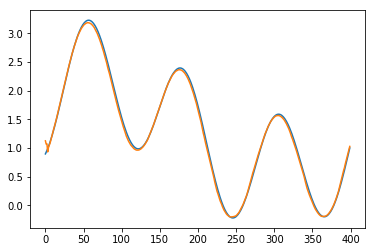

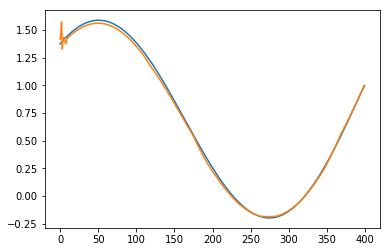

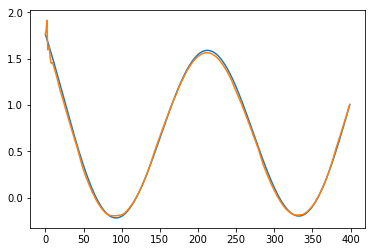

In [17]:
data = X_valid
pred = ef.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])